In [2]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn import metrics 
from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import GridSearchCV

%precision %.7g
%matplotlib inline

# KNN

## 1. Explore

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/diabetes2.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 2. Build and Evaluate Model

In [4]:
predictors = ["BMI", "BloodPressure"]
X = data[predictors]
y = data["Outcome"]

n_neighbors = 5

knn = KNeighborsClassifier(n_neighbors = n_neighbors)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

z = StandardScaler()
z.fit(X_train)
Xz_train = z.transform(X_train)
Xz_test = z.transform(X_test)

knn.fit(Xz_train,y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

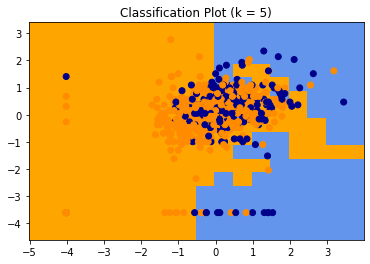

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plotKNN(X,y, title, n_neighbors, model):
    #adapted from: https://pythonspot.com/k-nearest-neighbors/
    h = .5  # step size in the mesh
    # Create color maps
    cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
    cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])
    # calculate min, max and limits
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h))

    # predict class using data and kNN classifier
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Classification Plot (k = %i)" % (n_neighbors))
    plt.show()
    
    
plotKNN(X = Xz_train,y = y_train, title = "KNN", n_neighbors = n_neighbors, model = knn)

In [6]:
knn.score(Xz_test,y_test)

0.6168831168831169

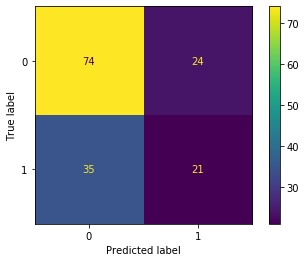

In [7]:
plot_confusion_matrix(knn, Xz_test, y_test)

# Parameter Tuning

## Option 1: By Hand

In [8]:
predictors = ["BMI", "BloodPressure"]

X = data[predictors]
y = data["Outcome"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)


X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size = 0.2)

poss_k = [1,2,3,4,5,6,7,8,9,10]
acc = {}

for k in poss_k:
    knn3 = KNeighborsClassifier(n_neighbors = k)
    knn3.fit(X_train2,y_train2)
    acc[k] = knn3.score(X_val,y_val)
print(acc)

chosen_k = max(acc, key=acc.get)
print(chosen_k)

knn_final = KNeighborsClassifier(n_neighbors = chosen_k)
knn_final.fit(X_train,y_train)

knn_final.score(X_test,y_test)

{1: 0.6097560975609756, 2: 0.6991869918699187, 3: 0.5853658536585366, 4: 0.6422764227642277, 5: 0.6422764227642277, 6: 0.6178861788617886, 7: 0.6341463414634146, 8: 0.6341463414634146, 9: 0.6260162601626016, 10: 0.6260162601626016}
2


0.6363636363636364

## Option 2: By hand (but make it k-fold)

In [9]:
predictors = ["BMI", "BloodPressure"]

X = data[predictors]
y = data["Outcome"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

poss_k = [1,2,3,4,5,6,7,8,9,10]
acc = {}

for k in poss_k:
    kf = KFold(n_splits = 5)
    knn3 = KNeighborsClassifier(n_neighbors = k)
    
    acc[k] = np.mean(cross_val_score(knn3, X_train, y_train, cv = kf))

print(acc)

chosen_k = max(acc, key=acc.get)
print(chosen_k)

knn_final = KNeighborsClassifier(n_neighbors = chosen_k)
knn_final.fit(X_train,y_train)

knn_final.score(X_test,y_test)

{1: 0.591203518592563, 2: 0.6416100226576036, 3: 0.623777155804345, 4: 0.6465147274423564, 5: 0.6058909769425563, 6: 0.6286018925763027, 7: 0.6074770091963215, 8: 0.62369718779155, 9: 0.6205117952818873, 10: 0.6351192856190857}
4


0.6623376623376623

## Option 3 (recommended): Grid Search

In [10]:
# what K do I use??

predictors = ["BMI", "BloodPressure"]

X = data[predictors]
y = data["Outcome"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# create model
knn2 = KNeighborsClassifier()

# choose potential values of k
ks = {"n_neighbors": range(1,30)}

# use grid search to find best parameters
grid = GridSearchCV(knn2,ks, scoring = "accuracy", cv = 5)

knnmod = grid.fit(X_train, y_train)

In [11]:
knnmod.best_estimator_.get_params()["n_neighbors"]

18

In [12]:
knnmod.best_score_
# more things you can pull: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

0.6644675463148074

In [13]:
knnmod.score(X_test,y_test)

0.6103896103896104

# In Class

In [15]:
admit = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/GradAdmissions.csv")
admit.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Admitted
0,1,337,118,4,4.5,4.5,9.65,1,1
1,2,324,107,4,4.0,4.5,8.87,1,1
2,3,316,104,3,3.0,3.5,8.00,1,1
3,4,322,110,3,3.5,2.5,8.67,1,1
4,5,314,103,2,2.0,3.0,8.21,0,1


0.88


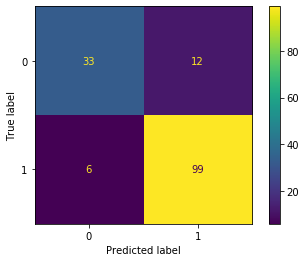

In [22]:
features = ["GRE Score", "TOEFL Score", "CGPA"]

X = admit[features]
y = admit["Admitted"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

z = StandardScaler()
X_train = z.fit_transform(X_train)
X_test = z.transform(X_test)

knn = KNeighborsClassifier(n_neighbors = 10)

knn.fit(X_train, y_train)

print(knn.score(X_test,y_test))

plot_confusion_matrix(knn, X_test, y_test)

0.8666666666666667


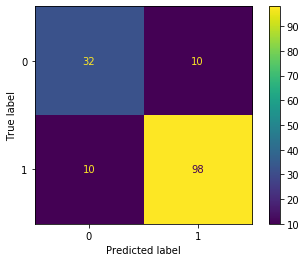

In [25]:
features = ["GRE Score", "TOEFL Score", "CGPA"]

X = admit[features]
y = admit["Admitted"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

z = StandardScaler()
X_train = z.fit_transform(X_train)
X_test = z.transform(X_test)

knn = KNeighborsClassifier()

ks = {"n_neighbors": range(1,20)}

# use grid search to find best parameters
grid = GridSearchCV(knn,ks, scoring = "accuracy", cv = 10)

knnmod = grid.fit(X_train, y_train)

print(knnmod.score(X_test,y_test))

plot_confusion_matrix(knnmod, X_test, y_test)